# 5. PREPROCESSING

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [3]:
!pip install memory_profiler
!pip install tracemalloc
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from memory_profiler import memory_usage
import time
import tracemalloc
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams["figure.figsize"] = (10,6)

ERROR: Could not find a version that satisfies the requirement tracemalloc (from versions: none)
ERROR: No matching distribution found for tracemalloc


# Load and Prepare NSL-KDD Dataset

In [8]:
columns = (['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
           'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
           'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
           'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
           'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
           'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
           'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
           'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
           'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
           'attack', 'level'])

df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/Datasets/NSL-KDD/KDDTrain+.txt", header=None, names=columns)
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/Datasets/NSL-KDD/KDDTest+.txt",header=None,names=columns)

df_train.columns = columns
df_test.columns = columns

# Load datasets

In [9]:
df_train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.170,0.030,0.170,0.000,0.000,0.000,0.050,0.000,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.000,0.600,0.880,0.000,0.000,0.000,0.000,0.000,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.100,0.050,0.000,0.000,1.000,1.000,0.000,0.000,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.000,0.000,0.030,0.040,0.030,0.010,0.000,0.010,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.100,0.060,0.000,0.000,1.000,1.000,0.000,0.000,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.960,0.010,0.010,0.000,0.000,0.000,0.000,0.000,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.120,0.060,0.000,0.000,0.720,0.000,0.010,0.000,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.030,0.050,0.000,0.000,1.000,1.000,0.000,0.000,neptune,20


# Drop duplicate rows and check for missing values

In [11]:
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

print(f"Duplicate rows in training set: {df_train.duplicated().sum()}")
print(f"Duplicate rows in test set: {df_test.duplicated().sum()}")

Duplicate rows in training set: 0
Duplicate rows in test set: 0


In [12]:
print("Missing values per column:")
print(df_train.isnull().sum())

Missing values per column:
duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate   

# Convert attack labels to binary (normal/malicious)

In [13]:
df_train["binary_attack"] = df_train.attack.map(lambda a: "normal" if a == 'normal' else "malicious")
df_test["binary_attack"] = df_test.attack.map(lambda a: "normal" if a == 'normal' else "malicious")

# Drop original attack column

In [14]:
df_train.drop('attack', axis=1, inplace=True)
df_test.drop('attack', axis=1, inplace=True)

# ✅ Track System Metrics Before Processing

In [15]:
start_time = time.time()
cpu_before = psutil.cpu_percent(interval=None)
mem_before = psutil.virtual_memory().used
disk_before = psutil.disk_io_counters().write_bytes + psutil.disk_io_counters().read_bytes

# Label encoding categorical features

In [16]:
df_train.select_dtypes(['object']).columns

Index(['protocol_type', 'service', 'flag', 'binary_attack'], dtype='object')

<!-- # Parallelized Label Encoding -->

In [17]:
clm = ['protocol_type', 'service', 'flag', 'binary_attack']
le = preprocessing.LabelEncoder()

for x in clm:
    df_train[x] = le.fit_transform(df_train[x])
    df_test[x] = le.fit_transform(df_test[x])


In [18]:
# Transform the categorical labels into binary format.
lb = LabelBinarizer()

# Transform the 'label' column to binary format.
df_train['binary_attack'] = lb.fit_transform(df_train['binary_attack'])

df_train


# Transform the 'label' column to binary format.
df_test['binary_attack'] = lb.fit_transform(df_test['binary_attack'])

df_test

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,binary_attack
0,0,1,45,1,0,0,0,0,0,0,...,0.040,0.060,0.000,0.000,0.000,0.000,1.000,1.000,21,0
1,0,1,45,1,0,0,0,0,0,0,...,0.000,0.060,0.000,0.000,0.000,0.000,1.000,1.000,21,0
2,2,1,19,9,12983,0,0,0,0,0,...,0.610,0.040,0.610,0.020,0.000,0.000,0.000,0.000,21,1
3,0,0,13,9,20,0,0,0,0,0,...,1.000,0.000,1.000,0.280,0.000,0.000,0.000,0.000,15,0
4,1,1,55,2,0,15,0,0,0,0,...,0.310,0.170,0.030,0.020,0.000,0.000,0.830,0.710,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,1,49,9,794,333,0,0,0,0,...,0.720,0.060,0.010,0.010,0.010,0.000,0.000,0.000,21,1
22540,0,1,22,9,317,938,0,0,0,0,...,1.000,0.000,0.010,0.010,0.010,0.000,0.000,0.000,21,1
22541,0,1,22,9,54540,8314,0,0,0,2,...,1.000,0.000,0.000,0.000,0.000,0.000,0.070,0.070,15,0
22542,0,2,11,9,42,42,0,0,0,0,...,0.990,0.010,0.000,0.000,0.000,0.000,0.000,0.000,21,1


# ✅ Track System Metrics After Processing

In [19]:
# 🏆 End Profiling
cpu_after = psutil.cpu_percent(interval=None)
mem_after = psutil.virtual_memory().used
disk_after = psutil.disk_io_counters().write_bytes + psutil.disk_io_counters().read_bytes
end_time = time.time()

In [20]:
# ✅ Performance Metrics
execution_time = end_time - start_time
cpu_usage_change = cpu_after - cpu_before
memory_used = (mem_after - mem_before) / (1024 ** 2)  # Convert bytes to MB
disk_io_used = (disk_after - disk_before) / (1024 ** 2)  # Convert bytes to MB

# ✅ Memory Usage Per Column
mem_usage = df_train.memory_usage(deep=True).sum() / (1024 ** 2)

# Print Computational Overhead Results

In [21]:
# 🏆 Print Performance Report
print(f"🚀 **Optimized Computational Overhead Report** 🚀")
print(f"⏳ **Execution Time:** {execution_time:.4f} seconds")
print(f"🔥 **CPU Usage Change:** {cpu_usage_change:.2f}%")
print(f"💾 **Disk I/O Usage:** {disk_io_used:.2f} MB")
print(f"📊 **Peak Memory Usage:** {memory_used:.2f} MB")
print(f"📂 **Memory Usage Per Column (Train Set):** {mem_usage:.2f} MB")

🚀 **Optimized Computational Overhead Report** 🚀
⏳ **Execution Time:** 36.7411 seconds
🔥 **CPU Usage Change:** -7.30%
💾 **Disk I/O Usage:** 5.21 MB
📊 **Peak Memory Usage:** -22.58 MB
📂 **Memory Usage Per Column (Train Set):** 41.33 MB


## 5.2 TRAIN-TEST-SPLIT

In [22]:
X_train = df_train.drop(['binary_attack', 'level'], axis=1)
y_train = df_train['binary_attack']
X_test = df_test.drop(['binary_attack', 'level'], axis=1)
y_test = df_test['binary_attack']

 # K-Best Feature Selection (F-test)

🎯 Top K-Best Features:
['protocol_type', 'service', 'flag', 'logged_in', 'count', 'serror_rate', 'srv_serror_rate', 'srv_rerror_rate', 'same_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_srv_rerror_rate']


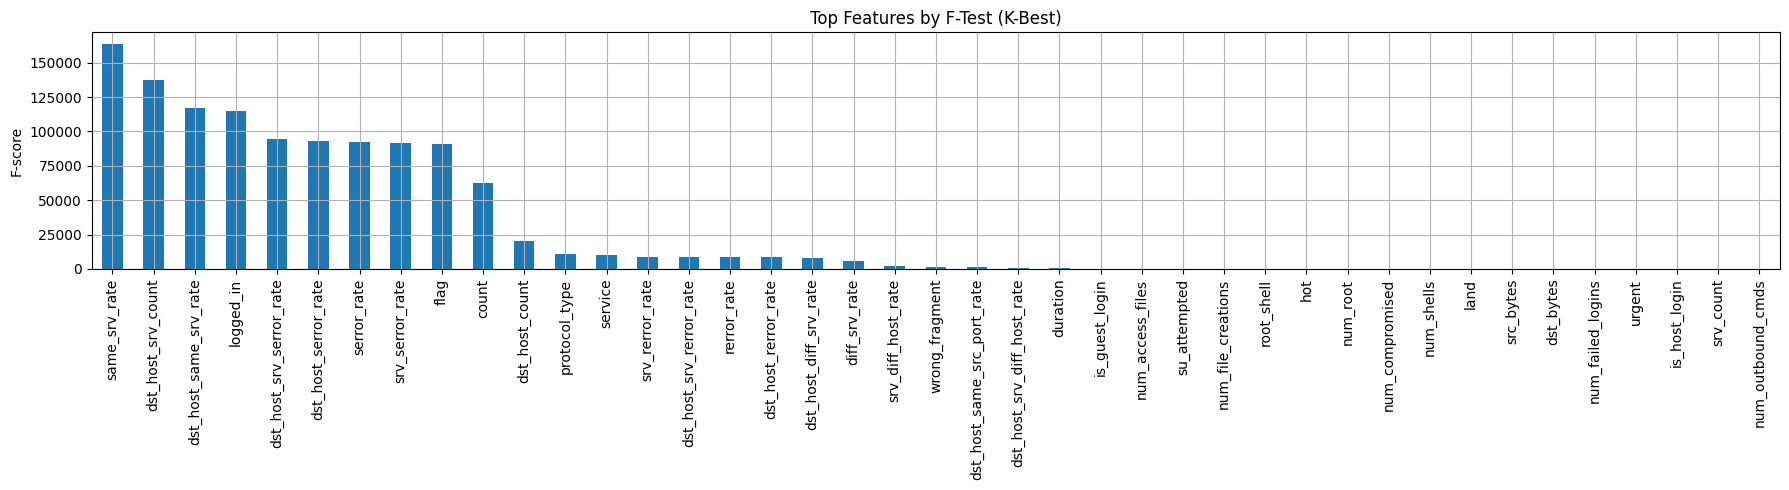

In [26]:
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import pandas as pd

# Apply K-Best with F-score
k = 15
kbest_selector = SelectKBest(score_func=f_classif, k=k)
X_train_kbest = kbest_selector.fit_transform(X_train, y_train)
X_test_kbest = kbest_selector.transform(X_test)

# Get selected feature names
kbest_features = X_train.columns[kbest_selector.get_support()].tolist()
print("🎯 Top K-Best Features:")
print(kbest_features)

# Create a full feature score mapping
kbest_scores = pd.Series(kbest_selector.scores_, index=X_train.columns)
kbest_scores = kbest_scores.sort_values(ascending=False)

# Plot all scores (not just top-k)
plt.figure(figsize=(18, 5))
kbest_scores.plot(kind='bar', title='Top Features by F-Test (K-Best)')
plt.ylabel('F-score')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


 # Information Gain (Mutual Info) Feature Selection

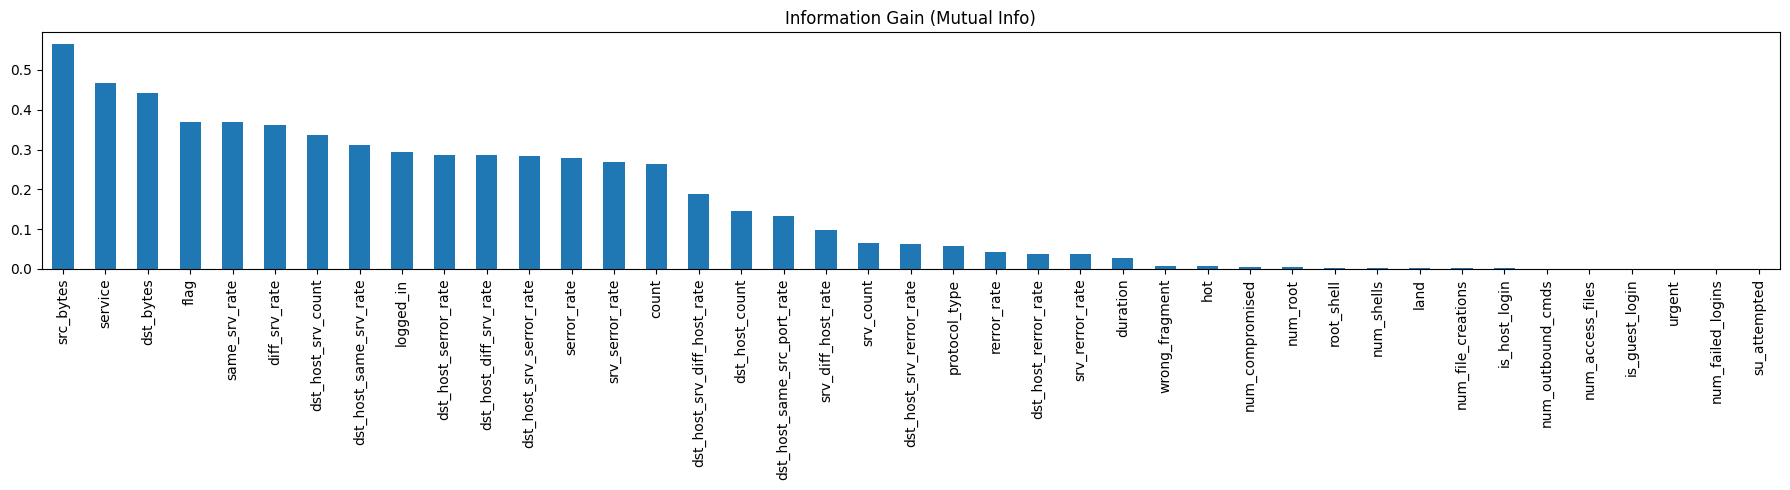

📌 Top Info Gain Features:
['src_bytes', 'service', 'dst_bytes', 'flag', 'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'logged_in', 'dst_host_serror_rate', 'dst_host_diff_srv_rate', 'dst_host_srv_serror_rate', 'serror_rate', 'srv_serror_rate', 'count']


In [27]:
# Compute mutual information
mi_scores = mutual_info_classif(X_train, y_train)
mi_series = pd.Series(mi_scores, index=X_train.columns)

# Plot
plt.figure(figsize=(18, 5))
mi_series.sort_values(ascending=False).plot(kind='bar', title='Information Gain (Mutual Info)')
plt.tight_layout()
plt.show()

# Select top 15 features
top_info_gain_features = mi_series.sort_values(ascending=False).head(15).index.tolist()
print("Top Info Gain Features:")
print(top_info_gain_features)

X_train_info = X_train[top_info_gain_features]
X_test_info = X_test[top_info_gain_features]


# Select top 15 features

In [ ]:
# top_features = mutual_info_series.sort_values(ascending=False).head(15).index.tolist()

# # Hardcoded features to always include
# hardcoded_features = ['duration', 'num_failed_logins', 'hot']

# # Ensure these features are included in the final selection
# final_features = list(dict.fromkeys(final_features))
# final_features = final_features[:18]

# X_train = X_train[final_features]
# X_test = X_test[final_features]

# Feature Scaling (for both selections)

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# K-Best
X_train_kbest_scaled = scaler.fit_transform(X_train_kbest)
X_test_kbest_scaled = scaler.transform(X_test_kbest)

# Information Gain
X_train_info_scaled = scaler.fit_transform(X_train_info)
X_test_info_scaled = scaler.transform(X_test_info)


# Choose One for Modeling (Optional)

In [30]:
# Option A: Use K-Best features
X_train_selected = X_train_kbest_scaled
X_test_selected = X_test_kbest_scaled

# Option B: Use Info Gain features
# X_train_selected = X_train_info_scaled
# X_test_selected = X_test_info_scaled

## Saving Train and Test Datasets

In [32]:
df_train_kbest = pd.DataFrame(X_train_selected, columns=kbest_features)
df_train_kbest['binary_attack'] = y_train.values
df_test_kbest = pd.DataFrame(X_test_selected, columns=kbest_features)
df_test_kbest['binary_attack'] = y_test.values

# Save training data
df_train.to_csv('/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/2_Modeling-Phase/train_and_test_datasets/NSL-KDD/train.csv', index=False)

# Save testing data
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/2_Modeling-Phase/train_and_test_datasets/NSL-KDD/test.csv', index=False)

print('Preprocessing complete. datasets saved to CSV files.')

Preprocessing complete. datasets saved to CSV files.


# -------------------------------
# SCALABILITY TEST (Execution Time vs. Dataset Size)
# -------------------------------

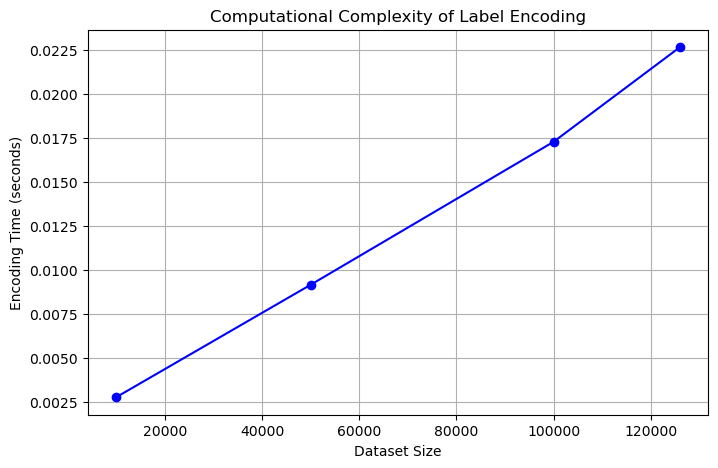

In [ ]:
sizes = [10_000, 50_000, 100_000, len(df_train)]
encoding_times = []

for size in sizes:
    df_sample = df_train.sample(n=size, random_state=42).copy()
    start_time = time.time()
    for x in clm:
        df_sample[x] = le.fit_transform(df_sample[x])
    encoding_times.append(time.time() - start_time)

# Plot the Computational Complexity of Label Encoding
plt.figure(figsize=(8, 5))
plt.plot(sizes, encoding_times, marker='o', color='b', linestyle='-')
plt.xlabel("Dataset Size")
plt.ylabel("Encoding Time (seconds)")
plt.title("Computational Complexity of Label Encoding")
plt.grid()
plt.show()